In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import sys
import numpy as np
import pickle as pkl
import time
import matplotlib.pyplot as plt

sys.path.append('../scripts')
import Baseline_classifiers as bc
from Classifier import Classifier
import ml_helper as mlh
import ml_evaluation as mle

# Baseline Klassifikatoren

#### Error Rate

Die gewählte Metrik zum Vergleich der Klassifikatoren ist die sogenannte **Fehlerrate (Error Rate)**

$$
E = \frac{F}{G}
$$

- $F$: Absolute Anzahl falsch klassifizierter Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

- $G$: Gesamtanzahl der zu klassifizierenden Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

(nimmt Werte zwischen 0 (keine Fehler) <br>
und 1 (ausschließlich Fehler) an)


#### Accuracy

Die Accuracy steht der Fehlerrate gegenüber und gibt den Anteil an richtigen Klassifizierungen an.

(nimmt Werte zwischen 0 (alles falsch) <br>
und 1 (alles richtig) an)

$$
Accuracy = \frac{T}{G} = 1 - E = 1 - \frac{F}{G}
$$

- $T$: Absolute Anzahl richtig klassifizierter Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

- $G$: Gesamtanzahl der zu klassifizierenden Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus


#### Berechnung der Error Rate

Berechnung der zu erwartenden Fehlerrate in Bezug auf alle Sequenzen eines bestimmten Organismus:

(Bei vorgegebener Wahrscheinlichkeitsverteilung)

$$
E = 1 - Accuracy = 1 - \frac{T}{G} = 1 - \frac{1}{G} \times \sum_{a \in A} \sum_{c\{a\} \in C\{a\}} (G_{c\{a\}} \times p_{c\{a\}})
$$

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

$T_{c\{a\}}$

## Datenvorbereitung

In [2]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]

dfs = {}
usage_biases = {}

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

for organism in organisms:
    dfs[organism] = pd.read_pickle(f"../data/{organism}/cleanedData.pkl")
    dfs[organism]['codons'] = dfs[organism]['sequence'].apply(group_codons)
    usage_biases[organism] = pd.read_pickle(f"../data/{organism}/usageBias.pkl")

display(dfs[organisms[0]].head())
display(usage_biases[organisms[0]])

,id,description,sequence,translation,seguid,codons
0,lcl|U00096.3_cds_AAC73112.1_1,lcl|U00096.3_cds_AAC73112.1_1 [gene=thrL] [loc...,"(A, T, G, A, A, A, C, G, C, A, T, T, A, G, C, ...","(M, K, R, I, S, T, T, I, T, T, T, I, T, I, T, ...",QuAqLUJXXhVXIJRPc+T7iMi0UqE,"[ATG, AAA, CGC, ATT, AGC, ACC, ACC, ATT, ACC, ..."
1,lcl|U00096.3_cds_AAC73113.1_2,lcl|U00096.3_cds_AAC73113.1_2 [gene=thrA] [loc...,"(A, T, G, C, G, A, G, T, G, T, T, G, A, A, G, ...","(M, R, V, L, K, F, G, G, T, S, V, A, N, A, E, ...",/p+3Jdgat4Fq0w2rqqay4xg8Bs4,"[ATG, CGA, GTG, TTG, AAG, TTC, GGC, GGT, ACA, ..."
2,lcl|U00096.3_cds_AAC73114.1_3,lcl|U00096.3_cds_AAC73114.1_3 [gene=thrB] [loc...,"(A, T, G, G, T, T, A, A, A, G, T, T, T, A, T, ...","(M, V, K, V, Y, A, P, A, S, S, A, N, M, S, V, ...",scFdp6oP+pW5HnvUww8MSi93ntM,"[ATG, GTT, AAA, GTT, TAT, GCC, CCG, GCT, TCC, ..."
3,lcl|U00096.3_cds_AAC73115.1_4,lcl|U00096.3_cds_AAC73115.1_4 [gene=thrC] [loc...,"(A, T, G, A, A, A, C, T, C, T, A, C, A, A, T, ...","(M, K, L, Y, N, L, K, D, H, N, E, Q, V, S, F, ...",EkFurFHdk7l6qKQ+5xRiBUhWM9U,"[ATG, AAA, CTC, TAC, AAT, CTG, AAA, GAT, CAC, ..."
5,lcl|U00096.3_cds_AAC73117.1_6,lcl|U00096.3_cds_AAC73117.1_6 [gene=yaaA] [loc...,"(A, T, G, C, T, G, A, T, T, C, T, T, A, T, T, ...","(M, L, I, L, I, S, P, A, K, T, L, D, Y, Q, S, ...",vJJ0yR31YORqwI12U79SgItYU3U,"[ATG, CTG, ATT, CTT, ATT, TCA, CCT, GCG, AAA, ..."


{'M': {'ATG': 1.0},
 'K': {'AAA': 0.7697623206014124, 'AAG': 0.23023767939858758},
 'R': {'CGC': 0.4038268652110177,
  'CGA': 0.06237173057634442,
  'CGT': 0.3853406372965049,
  'AGG': 0.019365789676722475,
  'CGG': 0.09391250675102229,
  'AGA': 0.03518247048838824},
 'I': {'ATT': 0.5083169031684763,
  'ATC': 0.4226625197856211,
  'ATA': 0.06902057704590264},
 'S': {'AGC': 0.27845605080764435,
  'TCA': 0.12152364933445466,
  'TCT': 0.1468839718121973,
  'AGT': 0.14924745526781313,
  'TCG': 0.15393092248354262,
  'TCC': 0.14995795029434794},
 'T': {'ACC': 0.439674039580908,
  'ACA': 0.1286767559177338,
  'ACG': 0.26575087310826545,
  'ACT': 0.16589833139309274},
 'G': {'GGT': 0.33815828251456553,
  'GGC': 0.40754006937045184,
  'GGG': 0.1490104509079368,
  'GGA': 0.10529119720704586},
 'N': {'AAC': 0.5532204543520803, 'AAT': 0.44677954564791966},
 'A': {'GCG': 0.35725717099593746,
  'GCA': 0.2125446263695679,
  'GCC': 0.27000932097571273,
  'GCT': 0.16018888165878195},
 '*': {'TGA': 0.2

In [3]:
def remove_longest_10_percent(df):
    # Bestimme die Länge jeder Aminosäuresequenz und sortiere sie absteigend
    sequence_lengths = df['translation'].str.len()
    sorted_lengths = sequence_lengths.sort_values(ascending=False)

    # Bestimme den Schwellenwert für die Länge (10% der längsten Sequenzen)
    threshold_length = sorted_lengths.quantile(0.9)

    # Filtere die DataFrame-Reihen basierend auf der Länge der Aminosäuresequenzen
    filtered_df = df[sequence_lengths <= threshold_length]
    return filtered_df

In [4]:
def remove_rows_with_X(df):
    rows_to_remove = []

    # Iteriere über die Zeilen des DataFrames
    for index, row in df.iterrows():
        # Überprüfe, ob 'X' in der Translation der aktuellen Zeile vorkommt
        if 'X' in row['translation']:
            rows_to_remove.append(index)  # Füge den Zeilenindex zur Liste hinzu

    # Entferne die Zeilen aus dem DataFrame
    filtered_df = df.drop(rows_to_remove)
    return filtered_df

In [5]:
print(dfs[organisms[2]].size)
dfs[organisms[2]] = remove_longest_10_percent(dfs[organisms[2]])
print(dfs[organisms[2]].size)
dfs[organisms[2]] = remove_rows_with_X(dfs[organisms[2]])
print(dfs[organisms[2]].size)
print(dfs[organisms[2]]['translation'].str.len().max())

548334
493614
493614
1401


## Baseline Klassifikator mit ungewichtetem Zufall

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = \frac{1}{len(C\{a\})}
$

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [16]:
calc_accuracies = {
    "Unweighted": {},
    "Weighted": {},
    "Max": {}
}

In [17]:
codon_amino_acid_frequencies = {}
for organism in organisms:
    with open(f'../data/{organism}/codon_amino_acid_frequencies.pkl', 'rb') as file:
        codon_amino_acid_frequencies[organism] = pkl.load(file)

In [18]:
for organism in organisms:
    accuracy = 0
    for amino_acid in mlh.amino_acids_to_codons.keys():
        if amino_acid == '_':
            continue
        for codon in mlh.amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon]
            codon_probability = 1 / len(mlh.amino_acids_to_codons[amino_acid])
            accuracy += codon_portion * codon_probability
    accuracy /= codon_amino_acid_frequencies[organism]['total']
    calc_accuracies["Unweighted"][organism] = accuracy
    print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.35409523515053154
Organismus Drosophila.Melanogaster - Accuracy: 0.35395116606283755
Organismus Homo.Sapiens - Accuracy: 0.3515989486161192


### Error Rates experimentell bestimmen

In [28]:
exp_accuracies = {
    "Unweighted": {},
    "Weighted": {},
    "Max": {}
}

In [20]:
pred_codons = {}
def test_classifier(classifier, organism):
    global pred_codons
    amino_seq = dfs[organism]['translation'].apply(lambda seq: list(seq))
    pred_codons = classifier.predict_codons(amino_seq)
    true_codons = dfs[organism]['codons']
    accuracy = classifier.calc_accuracy(true_codons, pred_codons)
    print(f"Organismus {organism} - Accuracy: {accuracy}")
    return accuracy

In [29]:
%%time
print("Ungewichteter Baseline Klassifikator")
for organism in organisms:
    start_time = time.time()
    seed = 42
    unweighted_bc = bc.Unweighted_Baseline_Classifier(seed)
    accuracy = test_classifier(unweighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_accuracies["Unweighted"][organism] = accuracy 

Ungewichteter Baseline Klassifikator
Organismus E.Coli - Accuracy: 0.35413026783947743
4.86
Organismus Drosophila.Melanogaster - Accuracy: 0.35384851615718116
199.38
Organismus Homo.Sapiens - Accuracy: 0.3518688374174608
98.79
CPU times: user 4min 46s, sys: 17.2 s, total: 5min 3s
Wall time: 5min 3s


In [30]:
#mlh.to_pickle(exp_accuracies, "../data/baseline_classifier_accuracies.pkl")

## Baseline Klassifikator mit Usage Bias gewichtetem Zufall

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = CUB_{c\{a\}}
$

$CUB_{c\{a\}}$: Codon Usage Bias für Codon c\{a\} für den betrachteten Organismus

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [24]:
for organism in organisms:
    accuracy = 0
    for amino_acid in mlh.amino_acids_to_codons.keys():
        if amino_acid == '_':
            continue
        for codon in mlh.amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon] / codon_amino_acid_frequencies[organism]['total']
            codon_probability = usage_biases[organism][amino_acid][codon]
            accuracy += codon_portion * codon_probability
    calc_accuracies["Weighted"][organism] = accuracy
    print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.4173126659061456
Organismus Drosophila.Melanogaster - Accuracy: 0.3946471708107408
Organismus Homo.Sapiens - Accuracy: 0.3768466042688616


### Error Rates experimentell bestimmen

In [31]:
%%time
print("Usage Bias Gewichteter Baseline Klassifikator")
for organism in organisms:
    start_time = time.time()
    seed = 42
    weighted_bc = bc.Bias_Weighted_Classifier(usage_biases[organism], seed)
    accuracy = test_classifier(weighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_accuracies["Weighted"][organism] = accuracy

Usage Bias Gewichteter Baseline Klassifikator
Organismus E.Coli - Accuracy: 0.4168798897388003
4.85
Organismus Drosophila.Melanogaster - Accuracy: 0.3945579154835799
198.4
Organismus Homo.Sapiens - Accuracy: 0.3783749842770212
97.75
CPU times: user 4min 44s, sys: 16.9 s, total: 5min 1s
Wall time: 5min 1s


In [32]:
#mlh.to_pickle(exp_accuracies, "../data/baseline_classifier_accuracies.pkl")

## Baseline Klassifikator der immer das nach Usage Bias wahrscheinlichste Codon wählt

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = 
\begin{cases}
1 & CUB_{c\{a\}} = max(CUB_{C\{a\}}) \\
0 & \text{sonst}
\end{cases}
$

$CUB_{C\{a\}}$: Menge an Codon Usage Bias für alle Codons der Menge $C\{a\}$ für den betrachteten Organismus <br>

$CUB_{c\{a\}}$: Codon Usage Bias für Codon c\{a\} für den betrachteten Organismus

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [27]:
for organism in organisms:
    accuracy = 0
    for amino_acid in mlh.amino_acids_to_codons.keys():
        if amino_acid == '_':
            continue
        codon_probs = usage_biases[organism][amino_acid]
        highest_prob_codon = max(codon_probs, key=codon_probs.get)
        for codon in mlh.amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon] / codon_amino_acid_frequencies[organism]['total']
            accuracy += codon_probs[highest_prob_codon] * codon_portion
    calc_accuracies["Max"][organism] = accuracy
    print(f"Organismus {organism} - Accuracy: {accuracy}")

Organismus E.Coli - Accuracy: 0.5184200344459031
Organismus Drosophila.Melanogaster - Accuracy: 0.49153717709301387
Organismus Homo.Sapiens - Accuracy: 0.43534545339540875


### Error Rates experimentell bestimmen

In [33]:
%%time
print("Usage Bias Maximum Baseline Klassifikator")
for organism in organisms:
    start_time = time.time()
    seed = 42
    max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases[organism], seed)
    accuracy = test_classifier(max_weighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_accuracies["Max"][organism] = accuracy

Usage Bias Maximum Baseline Klassifikator
Organismus E.Coli - Accuracy: 0.5180046344579663
3.7
Organismus Drosophila.Melanogaster - Accuracy: 0.4916659215423932
183.36
Organismus Homo.Sapiens - Accuracy: 0.44403057377859345
58.42
CPU times: user 3min 49s, sys: 16.8 s, total: 4min 5s
Wall time: 4min 5s


In [34]:
#mlh.to_pickle(exp_accuracies, "../data/baseline_classifier_accuracies.pkl")

### Accuracy in Segmenten

#### Testdaten laden

In [3]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]

dfs = {}
usage_biases = {}

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

for organism in organisms:
    dfs[organism] = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
    dfs[organism]['codons'] = dfs[organism]['sequence'].apply(group_codons)
    usage_biases[organism] = pd.read_pickle(f"../data/{organism}/usageBias.pkl")

#### Codon Prediction mit Max CUB

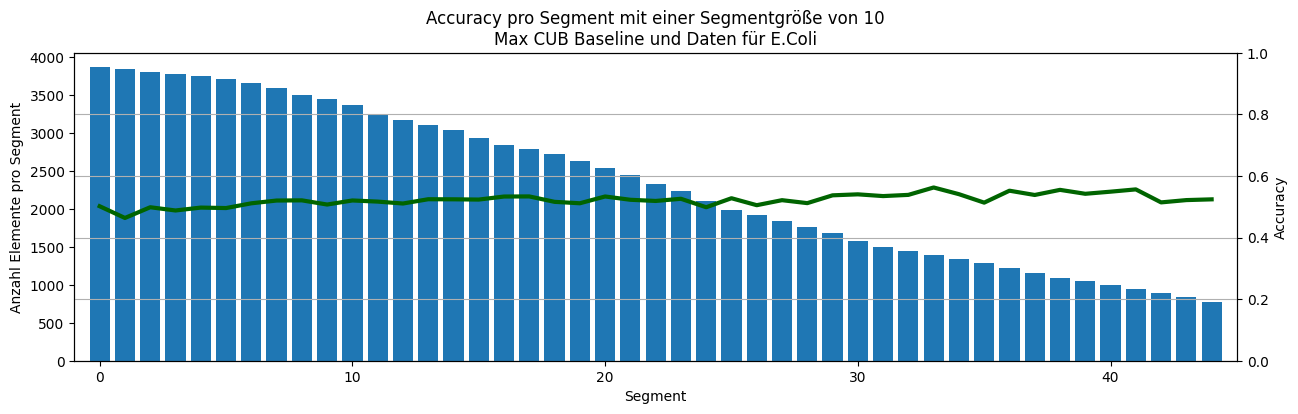

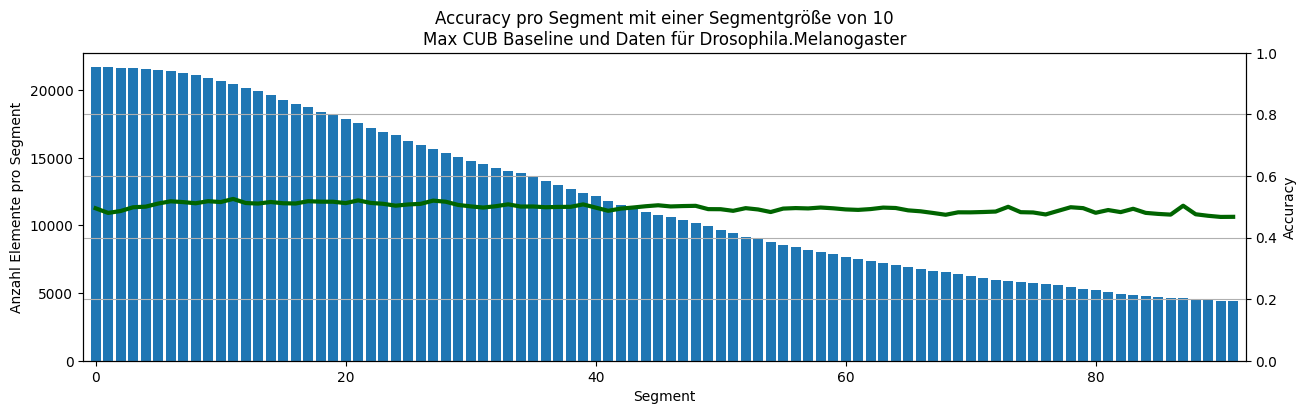

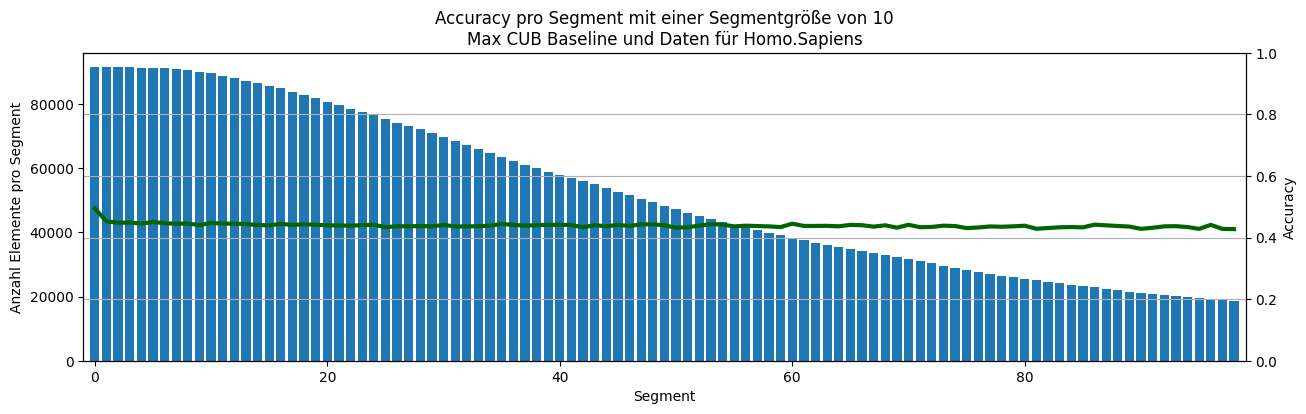

In [4]:
segment_size = 10

for organism in ["E.Coli","Drosophila.Melanogaster","Homo.Sapiens"]:
    max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases[organism])
    amino_seq = dfs[organism]['translation'].apply(lambda seq: list(seq))
    pred_codons = max_weighted_bc.predict_codons(amino_seq)
    true_codons = list(dfs[organism]['codons'])
    preds = []
    for codon_seq in pred_codons:
        preds.append(list(codon_seq[codon_seq != '']))

    seg_acc, seg_el = max_weighted_bc.calc_accuracy_per_segment(true_codons, preds, segment_size=segment_size, cut_data_at=0.2)
    mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nMax CUB Baseline und Daten für {organism}")

## Visualisierung der berechneten und experimentell bestimmten Error Rates

In [35]:
calc_accuracies

{'Unweighted': {'E.Coli': 0.35409523515053154,
  'Drosophila.Melanogaster': 0.35395116606283755,
  'Homo.Sapiens': 0.3515989486161192},
 'Weighted': {'E.Coli': 0.4173126659061456,
  'Drosophila.Melanogaster': 0.3946471708107408,
  'Homo.Sapiens': 0.3768466042688616},
 'Max': {'E.Coli': 0.5184200344459031,
  'Drosophila.Melanogaster': 0.49153717709301387,
  'Homo.Sapiens': 0.43534545339540875}}

In [37]:
exp_accuracies = mlh.from_pickle("../data/baseline_classifier_accuracies.pkl")
exp_accuracies

{'Unweighted': {'E.Coli': 0.35413026783947743,
  'Drosophila.Melanogaster': 0.35384851615718116,
  'Homo.Sapiens': 0.3518688374174608},
 'Weighted': {'E.Coli': 0.4168798897388003,
  'Drosophila.Melanogaster': 0.3945579154835799,
  'Homo.Sapiens': 0.3783749842770212},
 'Max': {'E.Coli': 0.5180046344579663,
  'Drosophila.Melanogaster': 0.4916659215423932,
  'Homo.Sapiens': 0.44403057377859345}}

In [38]:
# Calculating average accuracies for each classifier
average_accuracies = {classifier: np.mean(list(accuracies.values())) for classifier, accuracies in calc_accuracies.items()}
average_accuracies

{'Unweighted': 0.3532151166098294,
 'Weighted': 0.39626881366191596,
 'Max': 0.4817675549781086}

In [39]:
classifier_names = {
    "Unweighted": "Unweighted Baseline Classifier",
    "Weighted": "Usage Bias weighted Baseline Classifier",
    "Max": "Usage Bias Maximum Baseline Classifier"
}

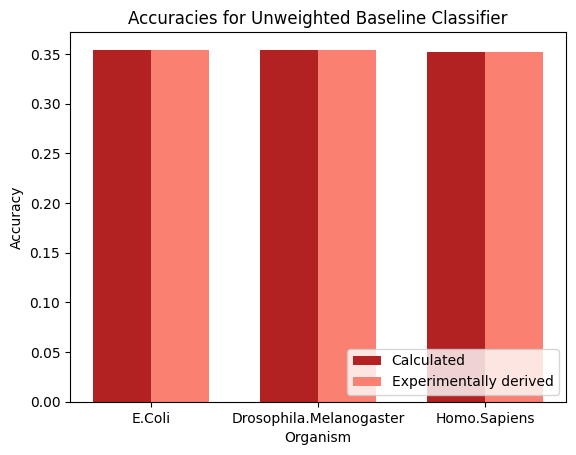

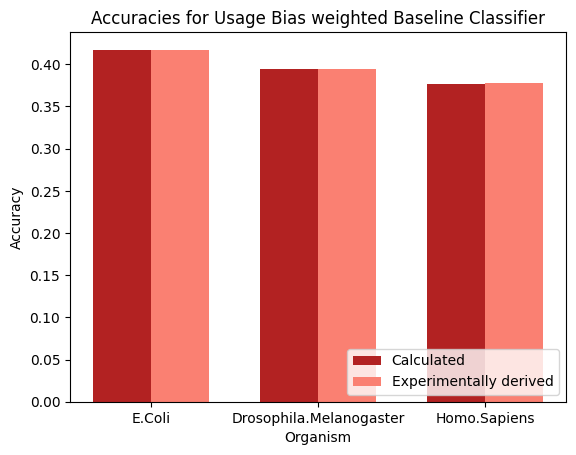

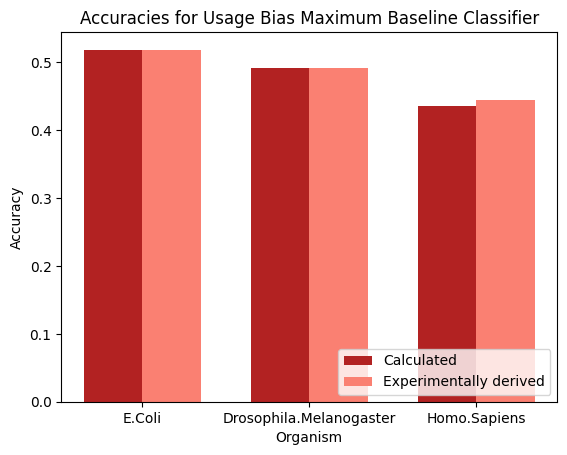

In [41]:
classifiers = list(calc_accuracies.keys())

bar_width = 0.35
index = np.arange(len(organisms))

for classifier in classifiers:
    calc_rates = [calc_accuracies[classifier][organism] for organism in organisms]
    exp_rates = [exp_accuracies[classifier][organism] for organism in organisms]

    fig, ax = plt.subplots()

    ax.bar(index, calc_rates, bar_width, label='Calculated', color='firebrick')
    ax.bar(index + bar_width, exp_rates, bar_width, label='Experimentally derived', color='salmon')

    ax.set_xlabel('Organism')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracies for {classifier_names[classifier]}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(organisms)
    ax.legend(loc='lower right')

    plt.show()

## Accuracy Comparison of all Baseline Classifiers

In [42]:
accuracies_data = {}
for classifier, organisms in calc_accuracies.items():
    for organism, value in organisms.items():
        if organism not in accuracies_data:
            accuracies_data[organism] = {}
        accuracies_data[organism][classifier] = value

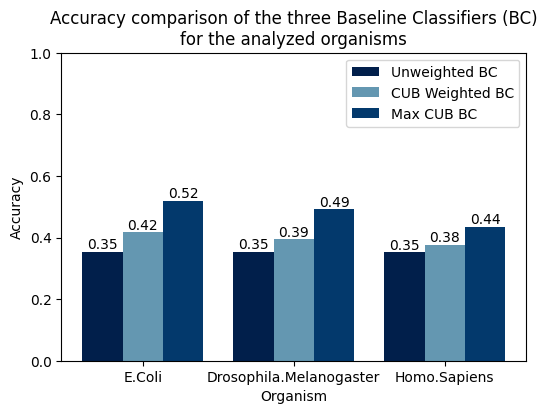

In [47]:
classifier_labels = ['Unweighted BC', 'CUB Weighted BC', 'Max CUB BC']
mle.plot_accuracies_comparison(accuracies_data, classifier_labels, f"Accuracy comparison of the three Baseline Classifiers (BC)\nfor the analyzed organisms", 2)